In [1]:
!pip install pydot

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [267]:
import boto3
import pydot
import random
import s3fs
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


INT_MAX = (2**32) - 1
s3 = boto3.client('s3')
BUCKET = 'ioccino-data'
FILENAME = 'mturk-coffee-flavors-2019-06-16_20:52:04.261095.csv'

In [265]:
def get_str_date():
    return str(datetime.now()).replace(' ', '_')

In [222]:
def get_rand_int():
    return random.randint(0, INT_MAX)

In [261]:
def df_to_s3(df):
    bytes_to_write = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem()
    with fs.open('s3://' + BUCKET + '/train_data/mturk-coffee-flavors-'+ get_str_date() +'.csv', 'wb') as f:
        f.write(bytes_to_write)

In [223]:
df = pd.read_csv('s3://' + BUCKET + '/data/' + FILENAME)
del df['Unnamed: 0']
df.columns = ['Answer.age', 'Gender', 'Target', 'Mood', 'Temperature']

In [224]:
print('columns len:', len(df.columns.values))

columns len: 5


In [225]:
"""
ocu = df['Target'].value_counts(dropna=False)
print(ocu)
_min = np.min(ocu)
for c in range(len(ocu)):
    ocu[c] -= _min

for i in range(len(df)):
    if (ocu[df['Target'][i]]) != 0:
        ocu[df['Target'][i]] -= 1
        df.drop(i, inplace=True)
"""

"\nocu = df['Target'].value_counts(dropna=False)\nprint(ocu)\n_min = np.min(ocu)\nfor c in range(len(ocu)):\n    ocu[c] -= _min\n\nfor i in range(len(df)):\n    if (ocu[df['Target'][i]]) != 0:\n        ocu[df['Target'][i]] -= 1\n        df.drop(i, inplace=True)\n"

In [226]:
df_target = df['Target'].copy()
del df['Target']

In [227]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df_target,
    random_state=get_rand_int(),
    test_size=0.3
)

In [232]:
for i in range(49, 50):
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred), i)

Accuracy: 0.4909560723514212 49


In [234]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# Train the model on training data
rf.fit(X_train, y_train);

In [236]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
#predictions = predictions.astype(int)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.82 degrees.


In [237]:
gnb = GaussianNB()

In [238]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
used_features =["Fare"]
y_pred = gnb.fit(X_train.values, y_train).predict(X_test)
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum(),
          100*(1-(y_test != y_pred).sum()/X_test.shape[0])
))
print("Std Fare not_survived {:05.2f}".format(np.sqrt(gnb.sigma_)[0][0]))
print("Std Fare survived: {:05.2f}".format(np.sqrt(gnb.sigma_)[1][0]))
print("Mean Fare not_survived {:05.2f}".format(gnb.theta_[0][0]))
print("Mean Fare survived: {:05.2f}".format(gnb.theta_[1][0]))

Number of mislabeled points out of a total 387 points : 199, performance 48.58%
Std Fare not_survived 00.01
Std Fare survived: 00.02
Mean Fare not_survived 00.02
Mean Fare survived: 00.02


In [239]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [240]:
y_pred = svclassifier.predict(X_test)  

In [241]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[  0  42   0   0]
 [  0 190   0   0]
 [  0  73   0   0]
 [  0  82   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.49      1.00      0.66       190
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        82

   micro avg       0.49      0.49      0.49       387
   macro avg       0.12      0.25      0.16       387
weighted avg       0.24      0.49      0.32       387



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [242]:
print("SVM performance {:05.2f}%".format(100*(1-(y_test != y_pred).sum()/X_test.shape[0])))

SVM performance 49.10%


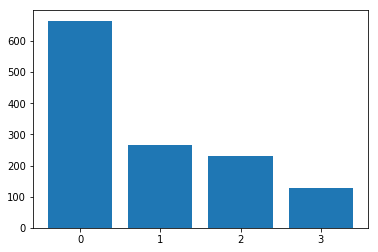

In [243]:
import matplotlib.pyplot as plt
plt.bar(x=['0', '1', '2', '3'], height=df_target.value_counts())
plt.show()

In [260]:
train_data = X_train.copy()
train_data['Target'] = y_train
train_data.head(2)

,Answer.age,Gender,Mood,Temperature,Target
1141,0.067406,0.0,0.0,0.028396,1
930,0.035767,0.0,0.0,0.028396,1


In [268]:
df_to_s3(train_data)